### Dogs vs cats:  распознавание / классификация изображений

In [1]:
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import random_brightness,random_rotation,random_shear,random_shift,random_zoom
from keras.optimizers import Adam, Adagrad
from keras import layers, models, optimizers
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
import cv2

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from warnings import filterwarnings 
filterwarnings('ignore')

Загрузка данных с диска

In [2]:
import zipfile 
import os      
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_file_test = '/content/drive/My Drive/CV_HW_3/test.zip'  
z_test        = zipfile.ZipFile(zip_file_test, 'r')
z_test.extractall()
# z_test.printdir()

In [4]:
zip_file_train = '/content/drive/My Drive/CV_HW_3/train.zip'  
z_train        = zipfile.ZipFile(zip_file_train, 'r')
z_train.extractall()
# z_train.printdir()

Предобработка данных 

In [36]:
import re
from random import shuffle
from glob import glob

train_files = glob('train/*.*.jpg')
test_files = glob('test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size =(224,224)):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)

# функция-генератор загрузки обучающих данных 
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений 
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

Примеры изображений для обучения

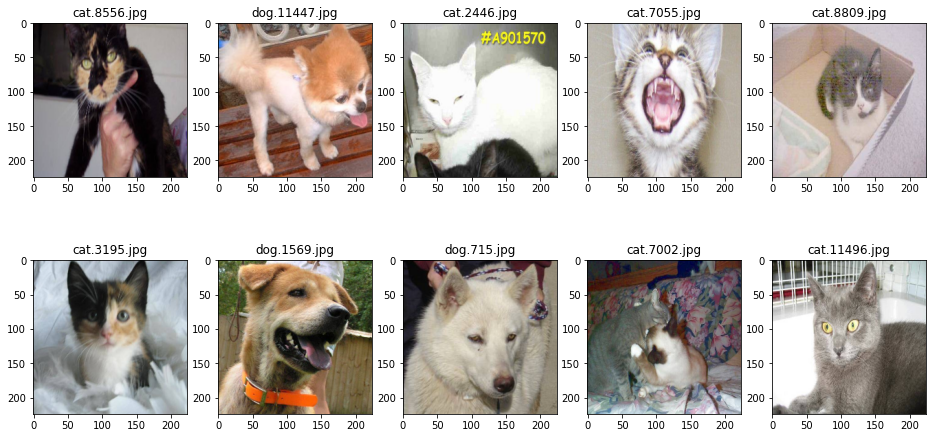

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [38]:
IMG_SIZE=(224,224)

VGG 16

In [39]:
import keras as ks
from keras.applications.vgg16 import VGG16 as vgg_16

Загружаем предобученную модель

In [40]:
vgg16 = vgg_16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [41]:
# фиксируем все веса предобученной сети
for layer in vgg16.layers:
    layer.trainable = False

In [42]:
vgg16.trainable = False

Архитектура исходной модели

In [43]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Добавляем слои

In [44]:
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras import layers
model_vgg16 = ks.models.Sequential()
model_vgg16.add(vgg16)
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(Flatten())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(1, activation='sigmoid'))

Архитектура рабочей модели

In [45]:
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               12845568  
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Компилируем и запускаем обучение

In [47]:
model_vgg16.compile(optimizer='Adagrad', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [48]:
val_samples = 5000  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
# запускаем процесс обучения
history_vgg16 = model_vgg16.fit_generator(fit_generator(train_files[val_samples:]),  # данные читаем функцией-генератором
        steps_per_epoch = 5,  # число вызовов генератора за эпоху
        epochs = 24,  # число эпох обучения # 
        validation_data=validation_data)

Epoch 1/24
5/5 [==============================] - 22s 5s/step - loss: 1.0570 - accuracy: 0.5291 - val_loss: 0.3503 - val_accuracy: 0.8832
Epoch 2/24
5/5 [==============================] - 21s 5s/step - loss: 0.5894 - accuracy: 0.7890 - val_loss: 0.1759 - val_accuracy: 0.9350
Epoch 3/24
5/5 [==============================] - 20s 5s/step - loss: 0.3762 - accuracy: 0.8552 - val_loss: 0.1384 - val_accuracy: 0.9456
Epoch 4/24
5/5 [==============================] - 20s 5s/step - loss: 0.4384 - accuracy: 0.8629 - val_loss: 0.1177 - val_accuracy: 0.9522
Epoch 5/24
5/5 [==============================] - 20s 5s/step - loss: 0.2516 - accuracy: 0.9029 - val_loss: 0.1033 - val_accuracy: 0.9586
Epoch 6/24
5/5 [==============================] - 21s 5s/step - loss: 0.3496 - accuracy: 0.8367 - val_loss: 0.0930 - val_accuracy: 0.9626
Epoch 7/24
5/5 [==============================] - 20s 5s/step - loss: 0.1989 - accuracy: 0.9287 - val_loss: 0.0859 - val_accuracy: 0.9652
Epoch 8/24
5/5 [==================

Визуализация результатов обучения

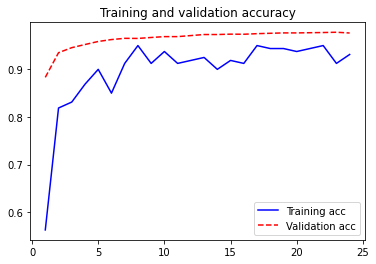

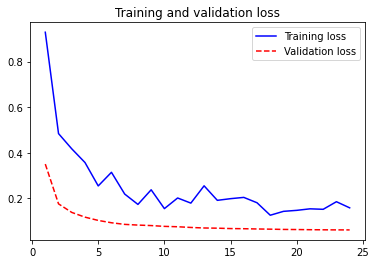

In [49]:
acc = history_vgg16.history['accuracy'] 
val_acc = history_vgg16.history['val_accuracy'] 
loss = history_vgg16.history['loss'] 
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,'b', label='Training acc') 
plt.plot(epochs, val_acc, 'r--', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss') 
plt.plot(epochs, val_loss, 'r--', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Сохраняем результаты обучения

In [ ]:
model.save('cats-dogs-vgg16.hdf5')

Предсказания на проверочной выборке

In [50]:
predicts_vgg16= model_vgg16.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

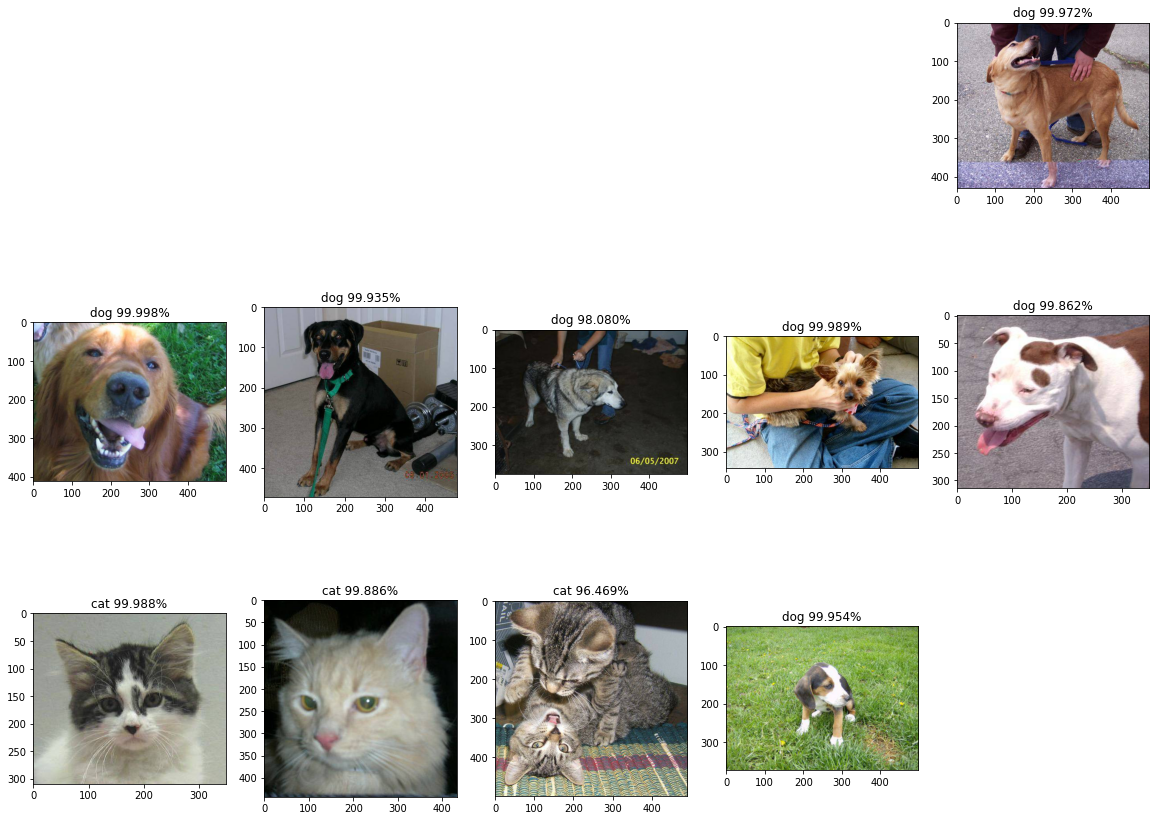

In [51]:
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], predicts_vgg16[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    if score < 0.5:
        plt.title('cat %.3f%%' % (100 - score * 100))
    else:
        plt.title('dog %.3f%%' % (score * 100))
    plt.imshow(plt.imread(path));

Подготовка данных для отправки на Kaggle

In [52]:
with open('/content/drive/My Drive/CV_HW_3/submit_model_vgg16.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files,predicts_vgg16):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

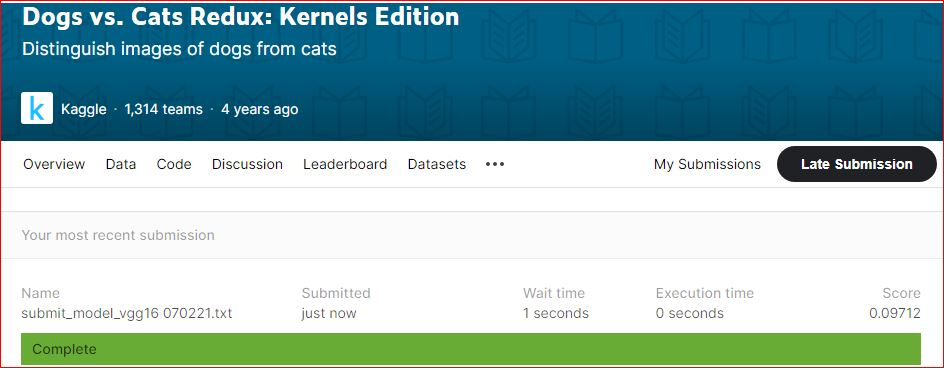

In [1]:
from IPython.display import Image
Image('Cats_vgg16_070221.jpg')

ResNet50

Загружаем предобученную модель Resnet50

In [77]:
from keras.applications import ResNet50

In [78]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [79]:
resnet50.trainable = False
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [80]:
model_resnet50 = ks.models.Sequential()
resnet50.trainable = False

Добавляем слои

In [81]:
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras import layers
model_resnet50 = ks.models.Sequential()
model_resnet50.add(resnet50)
model_resnet50.add(layers.Dropout(0.5))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(512, activation='relu'))
model_resnet50.add(BatchNormalization())
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(1, activation='sigmoid'))

Архитектура рабочей модели на базе Resnet50

In [82]:
model_resnet50.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               51380736  
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

Компилируем модель и запускаем обучение

In [83]:
model_resnet50.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr=1e-5), 
              metrics=['acc'])

In [84]:
# запускаем процесс обучения
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 5000  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
history_model_resnet50  = model_resnet50.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=5,  # число вызовов генератора за эпоху
        epochs = 33,        # число эпох обучения
        validation_data=validation_data)

Epoch 1/33
5/5 [==============================] - 20s 4s/step - loss: 1.0421 - acc: 0.5146 - val_loss: 0.4555 - val_acc: 0.7962
Epoch 2/33
5/5 [==============================] - 16s 4s/step - loss: 0.7547 - acc: 0.6546 - val_loss: 0.2073 - val_acc: 0.9184
Epoch 3/33
5/5 [==============================] - 16s 4s/step - loss: 0.4245 - acc: 0.7834 - val_loss: 0.1397 - val_acc: 0.9474
Epoch 4/33
5/5 [==============================] - 16s 4s/step - loss: 0.3911 - acc: 0.8201 - val_loss: 0.1101 - val_acc: 0.9572
Epoch 5/33
5/5 [==============================] - 16s 4s/step - loss: 0.2230 - acc: 0.8851 - val_loss: 0.0942 - val_acc: 0.9630
Epoch 6/33
5/5 [==============================] - 16s 4s/step - loss: 0.2401 - acc: 0.8931 - val_loss: 0.0844 - val_acc: 0.9662
Epoch 7/33
5/5 [==============================] - 16s 4s/step - loss: 0.1599 - acc: 0.9449 - val_loss: 0.0776 - val_acc: 0.9684
Epoch 8/33
5/5 [==============================] - 16s 4s/step - loss: 0.1739 - acc: 0.9332 - val_loss: 0

Визуализируем результаты обучения 

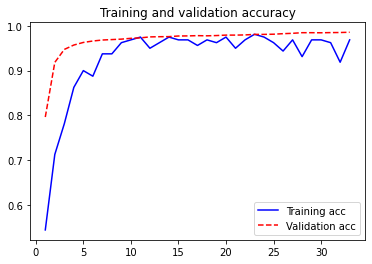

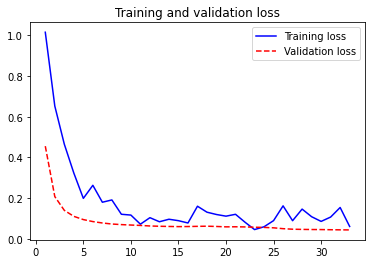

In [85]:
acc = history_model_resnet50.history['acc'] 
val_acc = history_model_resnet50.history['val_acc'] 
loss = history_model_resnet50.history['loss'] 
val_loss = history_model_resnet50.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,'b', label='Training acc') 
plt.plot(epochs, val_acc, 'r--', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss') 
plt.plot(epochs, val_loss, 'r--', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

In [ ]:
model.save('cats-dogs-resnet50.hdf5')

Предсказания на проверочной выборке

In [74]:
predicts_resnet50= model_resnet50.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

Подготовка данных на Kaggle

In [76]:
with open('/content/drive/My Drive/CV_HW_3/submit_model_resnet50.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files,predicts_resnet50):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

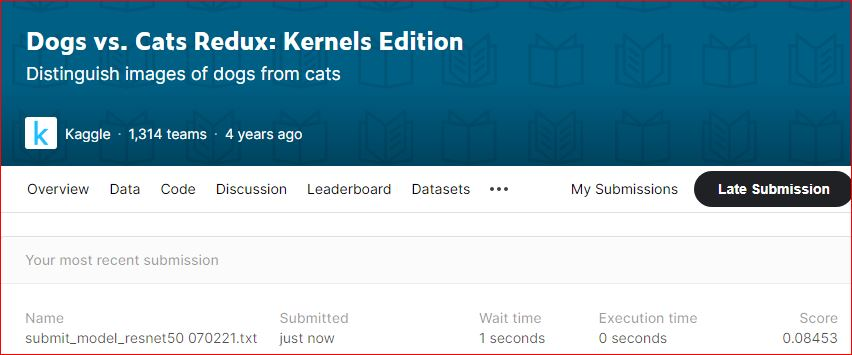

In [2]:
Image('Cats_resnet50_070221.jpg')

Работа над ошибками

Модель классификации наиболее склонна к сомнениям (чаще ошибается) на следующих типах изображений 

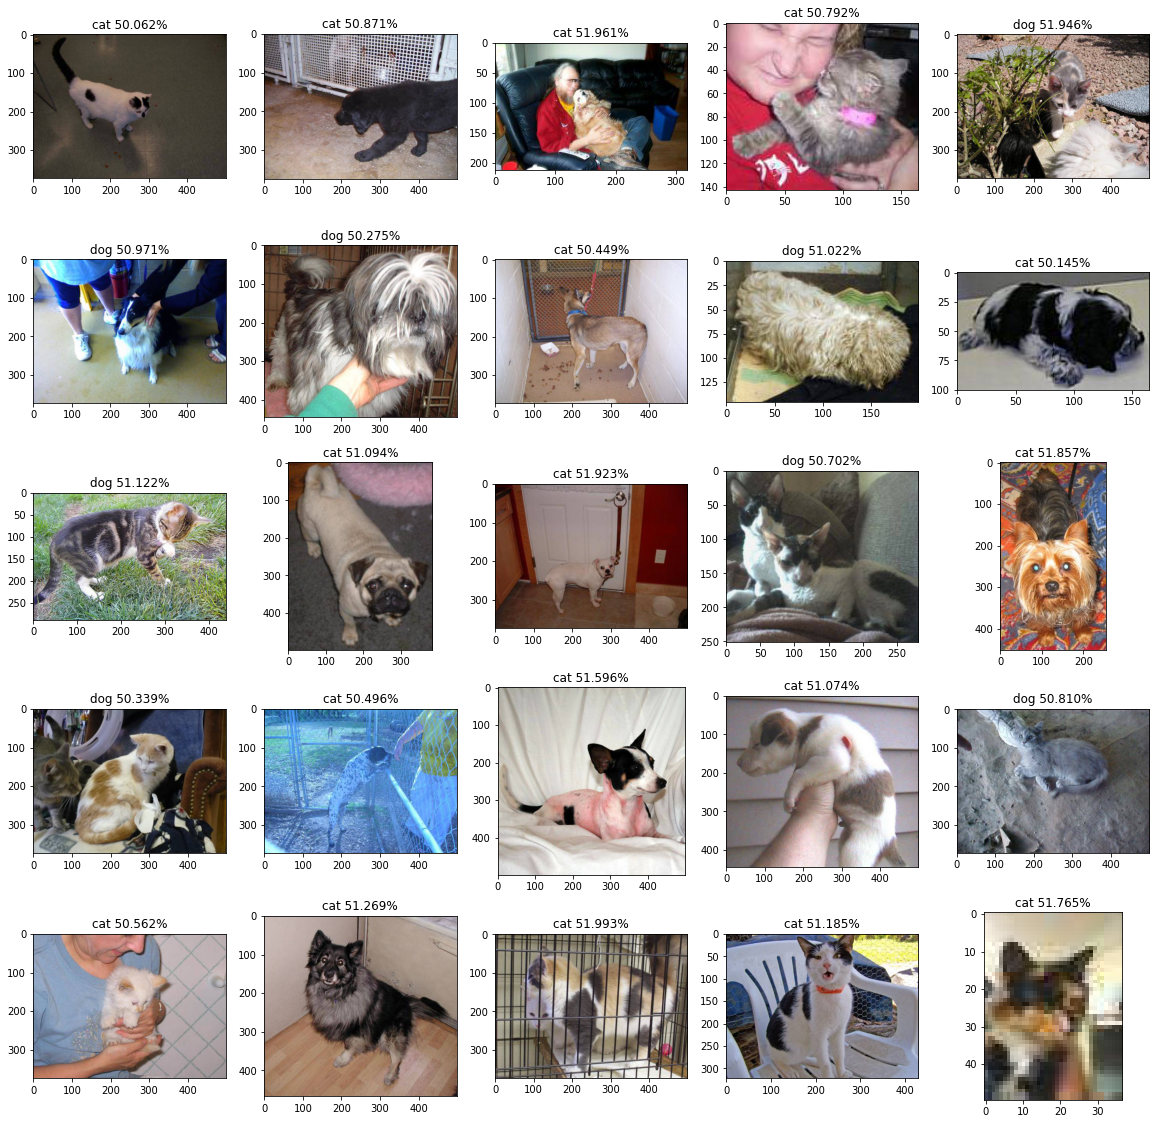

In [100]:
fig = plt.figure(figsize=(20, 20))
z=1

for i, (path, score) in enumerate(zip(test_files, predicts_resnet50), 1):
    if score > 0.48 and score < 0.52:
        subplot = fig.add_subplot(5,5, z)
        if score < 0.5:
            plt.title('cat %.3f%%' % (100 - score * 100))
        else:
            plt.title('dog %.3f%%' % (score * 100))
        plt.imshow(plt.imread(path));
        z+=1